In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
import yfinance as yf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import pytz

In [2]:
xmr = yf.Ticker("XMR-USD XMR-BTC XMR-EUR XMR-CNY")
df = yf.download(tickers = "XMR-USD",
                     period = "max",
                     interval = "1d")
df.reset_index(inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [3]:
### Get Gold, Silver and Copper closing prices in our dataframe's date range.

### Define date range
start_Date = df['Date'].min().date()
end_Date = df['Date'].max().date()

gold = yf.Ticker("GC=F")
gold_hist = gold.history(start=df['Date'].min(), end=df['Date'].max(), actions=False)
gold_hist.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
gold_hist.reset_index(inplace=True)
gold_hist['Date'] = gold_hist['Date'].dt.tz_convert(pytz.UTC)
gold_close=gold_hist[['Close']]

silver = yf.Ticker("SI=F")
silver_hist = silver.history(start=df['Date'].min(), end=df['Date'].max(), actions=False)
silver_hist.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
silver_hist.reset_index(inplace=True)
silver_hist['Date'] = silver_hist['Date'].dt.tz_convert(pytz.UTC)
silver_close=silver_hist[['Close']]

copper = yf.Ticker("HG=F")
copper_hist = copper.history(start=df['Date'].min(), end=df['Date'].max(), actions=False)
copper_hist.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
copper_hist.reset_index(inplace=True)
copper_hist['Date'] = copper_hist['Date'].dt.tz_convert(pytz.UTC)
copper_close=copper_hist[['Close']]
copper_date=copper_hist[['Date']]

In [4]:
### Get precious metals closing prices
metal_df  = pd.concat([gold_close, silver_close,copper_close], axis=1)
metal_df .columns = ['gold_close', 'silver_close', 'copper_close']
metal_df 

,gold_close,silver_close,copper_close
0,1285.599976,16.943001,3.0800
1,1272.400024,16.844000,3.0695
2,1277.300049,17.023001,3.1115
3,1281.500000,17.052000,3.0600
4,1276.500000,16.950001,3.0490
...,...,...,...
1485,1849.500000,21.740999,3.6425
1486,1861.000000,21.775999,3.6320
1487,1872.800049,21.957001,3.6140
1488,1869.300049,21.792000,3.5940


In [5]:
### Get other crypto coins close price to improve Model performance

bitcoin = yf.Ticker("BTC-USD")
bitcoin_hist = bitcoin.history(start=df['Date'].min(), end=df['Date'].max(), actions=False)
bitcoin_hist.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
bitcoin_hist.reset_index(inplace=True)
bitcoin_hist['Date'] = bitcoin_hist['Date'].dt.tz_convert(pytz.UTC)
bitcoin_close=bitcoin_hist[['Close']]

ethereum = yf.Ticker("ETH-USD")
ethereum_hist = ethereum.history(start=df['Date'].min(), end=df['Date'].max(), actions=False)
ethereum_hist.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
ethereum_hist.reset_index(inplace=True)
ethereum_hist['Date'] = ethereum_hist['Date'].dt.tz_convert(pytz.UTC)
ethereum_close=ethereum_hist[['Close']]

tether = yf.Ticker("USDT-USD")
tether_hist = tether.history(start=df['Date'].min(), end=df['Date'].max(), actions=False)
tether_hist.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
tether_hist.reset_index(inplace=True)
tether_hist['Date'] = tether_hist['Date'].dt.tz_convert(pytz.UTC)
tether_close=tether_hist[['Close']]

bnb = yf.Ticker("BNB-USD")
bnb_hist = bnb.history(start=df['Date'].min(), end=df['Date'].max(), actions=False)
bnb_hist.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
bnb_hist.reset_index(inplace=True)
bnb_hist['Date'] = bnb_hist['Date'].dt.tz_convert(pytz.UTC)
bnb_close=bnb_hist[['Close']]

xrp = yf.Ticker("XRP-USD")
xrp_hist = xrp.history(start=df['Date'].min(), end=df['Date'].max(), actions=False)
xrp_hist.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
xrp_hist.reset_index(inplace=True)
xrp_hist['Date'] = xrp_hist['Date'].dt.tz_convert(pytz.UTC)
xrp_close=xrp_hist[['Close']]
# xrp_date=xrp_hist[['Date']]..strftime("%Y-%m-%d")


In [6]:
### Create a df for other crypto coins

crypto_df  = pd.concat([bitcoin_close, ethereum_close,tether_close,bnb_close, xrp_close], axis=1)
crypto_df .columns = ['bitcoin_close', 'ethereum_close', 'tether_close', 'bnb_close', 'xrp_close']
crypto_df

,bitcoin_close,ethereum_close,tether_close,bnb_close,xrp_close
0,7143.580078,320.884003,1.008180,1.990770,0.217488
1,6618.140137,299.252991,1.006010,1.796840,0.206483
2,6357.600098,314.681000,1.008990,1.670470,0.210430
3,5950.069824,307.907990,1.012470,1.519690,0.197339
4,6559.490234,316.716003,1.009350,1.686620,0.203442
...,...,...,...,...,...
2162,26873.320312,1566.254761,0.999752,206.533417,0.488838
2163,26756.798828,1539.612427,0.999708,205.229416,0.483050
2164,26862.375000,1552.089478,0.999960,206.036118,0.485699
2165,26861.707031,1555.256836,1.000106,206.601898,0.486775


In [7]:
### Get 'S&P 500' stock market index

sp = yf.Ticker("^GSPC")
sp_hist = sp.history(start=df['Date'].min(), end=df['Date'].max(), actions=False)
sp_hist.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
sp_hist.reset_index(inplace=True)
sp_hist['Date'] = sp_hist['Date'].dt.tz_convert(pytz.UTC)
sp_close=sp_hist[['Close']]

In [8]:
### Combine Other Crypto coins and precious metals' dataframes
crypto_metal_df = pd.concat([crypto_df, metal_df, sp_close ], axis=1)

### Assign column names
crypto_metal_df.columns = ['bitcoin_close', 'ethereum_close', 'tether_close', 'bnb_close', 'xrp_close',
                     'gold_close', 'silver_close', 'copper_close','sp_close']
### Fill missing values using interpolate technique
crypto_metal_df.interpolate(inplace=True)

### Combine to main df
crypto_metal_df1=pd.concat([df, crypto_metal_df], axis=1)

df = crypto_metal_df1.copy()

### Fill missing values using interpolate technique
df.interpolate(inplace=True)

In [9]:
def clean_hash_difficulty_files(files: list):
    final_files = []
    for file in files:
        # file = pd.read_csv(f'{file}', index_col=None)
        # D:\quera\tamrin\faz2\XMR_difficulty.csv
        file = pd.read_csv(f'./data_phase2/{file}', index_col=None)
        file.drop(columns=['Unnamed: 0'], inplace=True)

        ### Convert hourly difficulty rates to daily
        
        ### First, ensure that the 'time' column is of datetime type
        file['time'] = pd.to_datetime(file['time'])

        ### Set 'time' as the index for the DataFrame
        file.set_index('time', inplace=True)

        ### Use the resample method to aggregate hourly data to daily data
        rate = ''
        if 'difficulty' in file.columns:
            rate_col = 'difficulty'
        elif 'hash' in file.columns:
            rate_col = 'hash'
        converted_rate = file[rate_col].resample('D').mean()
        converted_rate = pd.DataFrame(converted_rate)
        converted_rate.reset_index(inplace=True)
        
        ### Remove UTC time format from its time column
        converted_rate['time'] = converted_rate['time'].dt.tz_localize(None)

        ### Filter converted_rate date range to correspond to date range in df( aka XMR-Monero)
        start_date = df['Date'].min()
        ### converted_rate ends in 2023-10-08 so forcibly we have to cut df short to 2023-10-08 
        end_date = df['Date'].max()

        ### Final file named With daily rates instead of hourly 
        ### And Correct date range
        ### Note : There are still 6 rows missing in converted_rate_with_range which has to be dropped from df  
        converted_rate_with_range = converted_rate[
            (converted_rate['time'] >= start_date) & (converted_rate['time'] <= end_date)
        ]
        converted_rate_with_range.reset_index(drop=True, inplace=True)
        converted_rate_with_range = converted_rate_with_range.rename(columns={'time': 'Date'})
        final_files.append(converted_rate_with_range)
    return final_files

In [10]:
### difficulty_hash_final_files contains a list with 2 elements 
### At index 0 it has final xmr_difficulty file
### At index 1 it has final xmr_hash file 
difficulty_hash_final_files = clean_hash_difficulty_files(files=['XMR_difficulty.csv', 'XMR_hash.csv'])

In [11]:
### Merge difficulty and hash into XMR-Monro (our main df)
for file in difficulty_hash_final_files:
    df = pd.merge(df, file, on='Date')
df

,Date,Open,High,Low,Close,Adj Close,Volume,bitcoin_close,ethereum_close,tether_close,bnb_close,xrp_close,gold_close,silver_close,copper_close,sp_close,difficulty,hash
0,2017-11-09,112.531998,123.404999,112.219002,120.779999,120.779999,86864600,7143.580078,320.884003,1.008180,1.990770,0.217488,1285.599976,16.943001,3.0800,2584.620117,2.806786e+10,2.338989e+08
1,2017-11-10,121.344002,121.665001,101.757004,105.585999,105.585999,84614000,6618.140137,299.252991,1.006010,1.796840,0.206483,1272.400024,16.844000,3.0695,2582.300049,2.805339e+10,2.337782e+08
2,2017-11-11,105.750000,127.106003,103.877998,119.615997,119.615997,107708000,6357.600098,314.681000,1.008990,1.670470,0.210430,1277.300049,17.023001,3.1115,2584.840088,2.805339e+10,2.337782e+08
3,2017-11-12,119.597000,133.675003,110.617996,123.856003,123.856003,144948000,5950.069824,307.907990,1.012470,1.519690,0.197339,1281.500000,17.052000,3.0600,2578.870117,2.805339e+10,2.337782e+08
4,2017-11-13,128.960007,136.528000,120.921997,123.402000,123.402000,116200000,6559.490234,316.716003,1.009350,1.686620,0.203442,1276.500000,16.950001,3.0490,2564.620117,2.805339e+10,2.337782e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,2023-10-04,147.168442,150.702347,145.940781,150.469055,150.469055,59400400,27799.394531,1647.838135,1.000437,213.413086,0.532931,1927.400024,22.726999,3.5800,4327.779785,3.423015e+11,2.852512e+09
2156,2023-10-05,150.474197,151.328369,148.565491,149.623718,149.623718,55704972,27415.912109,1611.476440,1.000089,210.679672,0.523366,1927.400024,22.726999,3.5800,4327.779785,3.338542e+11,2.782118e+09
2157,2023-10-06,149.623337,152.669296,148.641647,151.992264,151.992264,49535004,27946.597656,1645.831543,1.000436,213.555527,0.526193,1927.400024,22.726999,3.5800,4327.779785,3.580862e+11,2.984052e+09
2158,2023-10-07,151.988235,155.247528,151.100983,155.212143,155.212143,61159796,27968.839844,1634.511230,1.000550,212.364471,0.521906,1927.400024,22.726999,3.5800,4327.779785,3.445453e+11,2.871211e+09


In [12]:
### Add Target vector as a separate column to dataframe for later reference
### This is Target Vector
df['Price_Direction'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

In [13]:
# df['HighLow'] = df['High'] - df['Low']
# df['OpenClose'] = df['Open'] - df['Close']
# df

In [14]:
### Calculate RSI Indicator

### First Calculate the difference of each day's price with prior day
change = df["Close"].diff()
change = change.dropna()

### Create two copies of the Closing price Series
change_up = change.copy()
change_down = change.copy()

change_up[change_up<0] = 0
change_down[change_down>0] = 0

### Verify no mistakes were made
change.equals(change_up+change_down)

### Calculate the rolling average of average up and average down
window_size = 14
avg_up = change_up.rolling(window_size).mean()
avg_down = change_down.rolling(window_size).mean().abs()

### Calculate RSI using its formula
rsi = 100 * avg_up / (avg_up + avg_down)

### Add RSI index to dataframe
df['RSI'] = rsi
rsi.isna().value_counts()

Close
False    2146
True       13
Name: count, dtype: int64

In [15]:
### Calculate SMA Indicator

### Get the window of series of observations of specified window size 
window_size = 2
windows = df['Close'].rolling(window_size) 
  
### Create a series of simple moving averages of each window 
sma = windows.mean() 

### Add SMA index to dataframe
df['SMA'] = sma

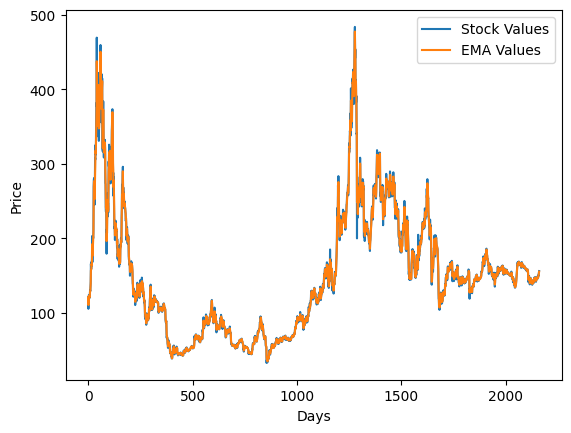

In [16]:
### Calculate EMA Indicator

ema = df['Close'].ewm(span=2, adjust=False).mean()
### Add EMA index to dataframe
df['EMA'] = ema

### Comparison plot b/w stock values & EMA
plt.plot(df['Close'], label="Stock Values")
plt.plot(ema, label="EMA Values")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show() 
### We can see that EMA index predicts out stock value (closing price) pretty good.

In [17]:
### Calculate Bollinger Band Indicator

sma = df['Close'].rolling(window=5).mean()
rstd = df['Close'].rolling(window=5).std()

upper_band = sma + 2 * rstd
lower_band = sma - 2 * rstd

### Option 1
### Calculate Band Width (Bollinger Band as single indicator)
# df['Band_Width'] = (upper_band - lower_band) / sma

### Option 2
### Calculate Bollinger band as separate indicators
df['Upper_Band'] = upper_band
df['Lower_Band'] = lower_band

In [18]:
### Calculate MACD Indicator

### Calculate Short-term (12 day) Exponential Moving Average (EMA)
short_term_ema = df['Close'].ewm(span=12, adjust=False).mean()

### Calculate Long-term (26 day) Exponential Moving Average (EMA)
long_term_ema = df['Close'].ewm(span=26, adjust=False).mean()

### Calculate MACD Line
macd = short_term_ema - long_term_ema

### Calculate Signal Line (9-day EMA of MACD)
signal_line = macd.ewm(span=9, adjust=False).mean()

### Add MACD and Signal Line to your DataFrame
df['MACD'] = macd
df['Signal_Line'] = signal_line

### Create a binary column for buy (1) and sell (0) signals
df['MACD_Signal'] = (df['MACD'] > df['Signal_Line']).astype(int)

In [19]:
### Drop NaN values because of the nature of RSI, EMA, SMA and MACD calculations >>> This is normal.
df.dropna(inplace=True)
### Reset Index
df.reset_index(drop=True, inplace=True)

### Assign features and target 
y = df['Price_Direction']
X = df.drop(columns=['Price_Direction', 'Date'])

In [20]:
### Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [21]:
### Split data into train and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [22]:
### Use Grid Search for optimal K

param_grid = {
    'n_neighbors': range(1, 30)  
}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 30)})

In [23]:
### Create and Train KNeighborsClassifier model 
best_n_neighbors = grid_search.best_params_['n_neighbors']
print(f"Best n_neighbors(or k) by grid search is : {best_n_neighbors}\n")
knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn.fit(X_train, y_train)

Best n_neighbors(or k) by grid search is : 27



KNeighborsClassifier(n_neighbors=27)

In [24]:
y_predict = knn.predict(X_test)

In [25]:
f1 = f1_score(y_test, y_predict)
print(f"F1 score : {f1 * 100}")
print(f"Precision score : {precision_score(y_test, y_predict) * 100}")
print(f"Recall score : {recall_score(y_test, y_predict) * 100}")
print(f"Recall score : {roc_auc_score(y_test, y_predict) * 100}")

F1 score : 59.583333333333336
Precision score : 56.97211155378486
Recall score : 62.44541484716157
Recall score : 54.08702903162099
